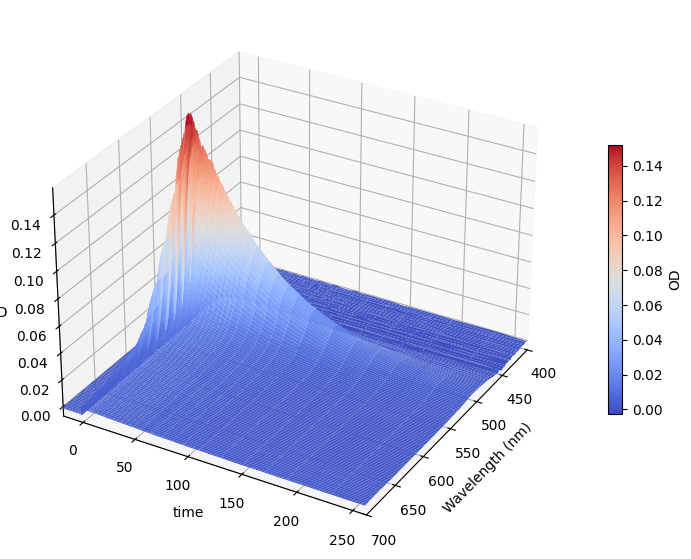

In [ ]:

import matplotlib .pyplot as plt 
import numpy as np 
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

data = pd.read_csv(r"DAS_ACN_10uL (1).csv")

time = data.iloc[1:,0].astype(float).values[:184]#Data from first column, skipping header 
wavelengths = data.columns[1:].astype(float)[199:489]  # First row (wavelengths) from the second column
od_values = data.iloc[1:185,199:489].astype(float).values  # OD values (excluding headers)

x_grid, y_grid = np.meshgrid(wavelengths, time)
z_values = od_values 

fig = plt.figure(figsize= [12,7])
ax = fig.add_subplot(111, projection='3d')

ax.view_init(30,30)# Adjust the viewing angle for better perspective

# Create a surface plot
p = ax.plot_surface(x_grid, y_grid, od_values, rstride=2, cstride=2, linewidth=0.1, cmap=cm.coolwarm)
cb = fig.colorbar(p, shrink=0.5)
cb.set_label('OD')

ax.set_ylabel('time')
ax.set_xlabel('Wavelength (nm)')
ax.set_zlabel('OD')  
ax.set_xlim(400,700)
ax.set_ylim(time.min(), time.max())

plt.show()

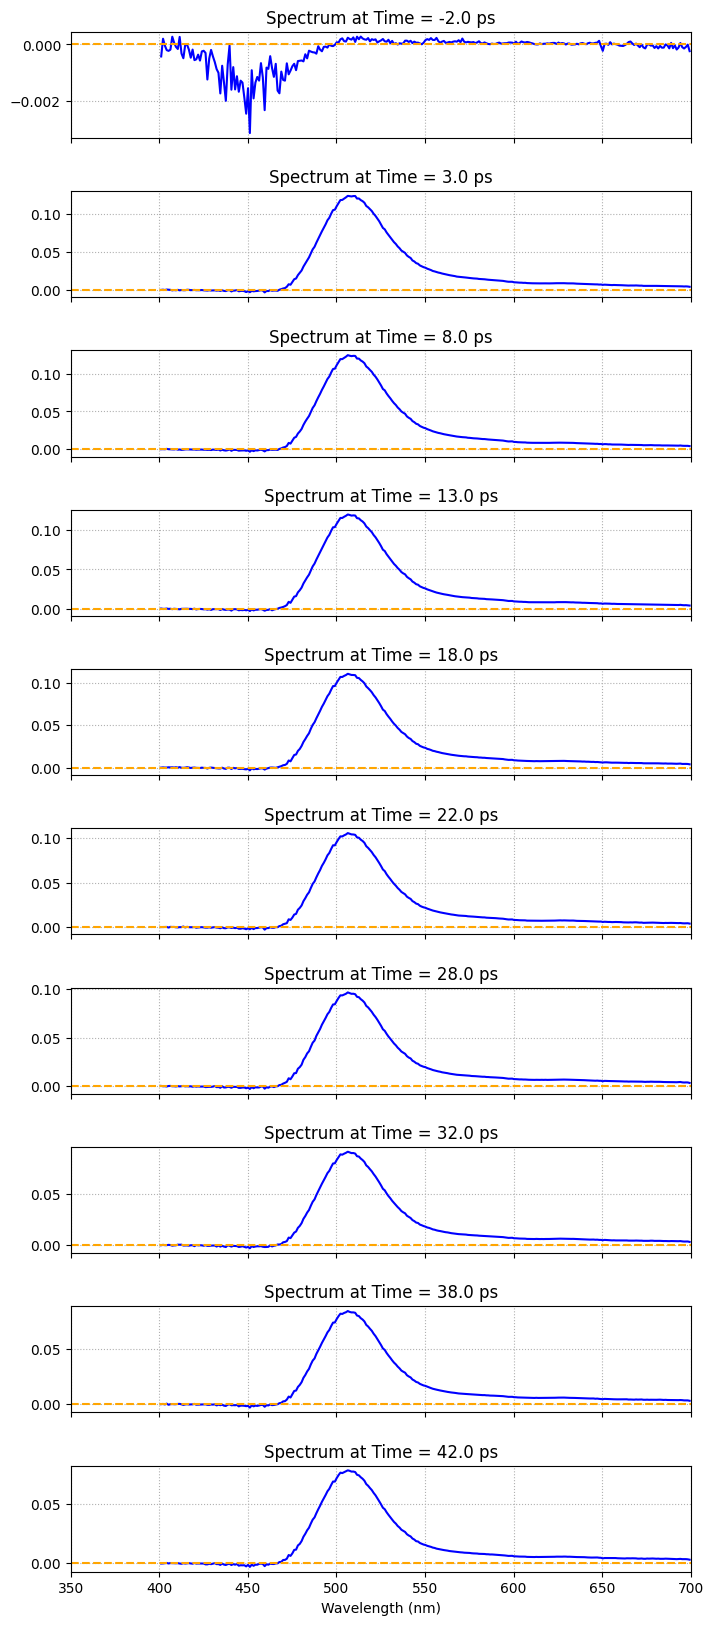

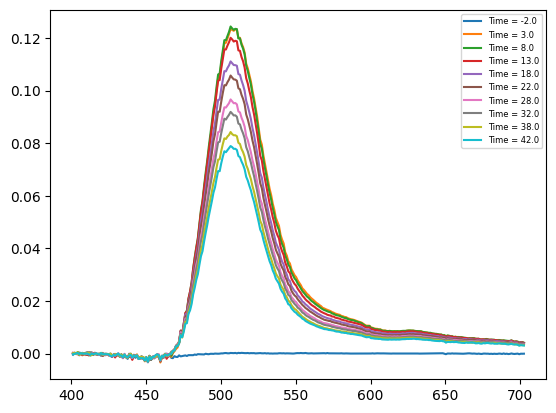

In [ ]:
## OD vs Wavelengths for different times (seperate plots) 

time_values = 3
increment = 5
time_index = []

for i in range(time_values):
    time_addition = 2 - increment * i
    time_index.append(np.argmin(np.abs(time + time_addition)))

# Define x-axis range (350-700 nm)
x_min, x_max = 350, 700

# Filter wavelengths and corresponding OD values
wavelength_mask = (wavelengths >= x_min) & (wavelengths <= x_max)
wavelengths_filtered = wavelengths[wavelength_mask]
od_values_filtered = od_values[:, wavelength_mask]

# Create subplots
fig, axes = plt.subplots(len(time_index), 1, figsize=(8, len(time_index) * 2), sharex=True)

for i, t in enumerate(time_index):
    axes[i].plot(wavelengths_filtered, od_values_filtered.T[:, t], color='blue')
    axes[i].plot([x_min, x_max], [0, 0], linestyle='--', color='orange')  # Dashed line
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_title(f'Spectrum at Time = {round(time[t],2)} ps')
    axes[i].grid(linestyle=':')

# Adjust spacing & labels
plt.subplots_adjust(hspace=0.5)
axes[-1].set_xlabel('Wavelength (nm)')  # X-axis label only on the last subplot

plt.show()


#Finding Eutectic Points
for i,t in enumerate(time_index):
    plt.plot(wavelengths, od_values.T[:, t],label='Time = {}'.format(round(time[t],2)))#Round off to two decimal places
plt.legend(loc = 'best', prop={'size': 6})
plt.show()


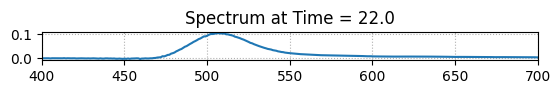

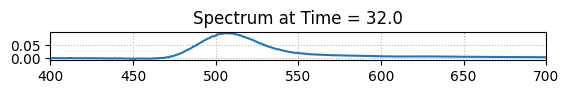

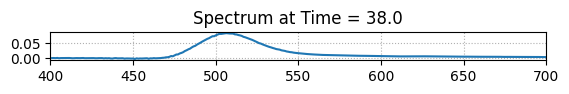

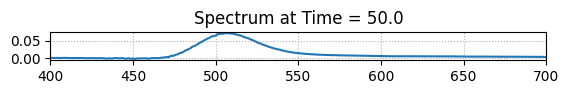

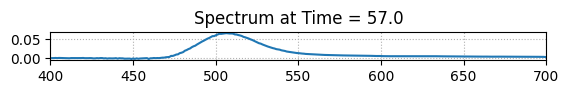

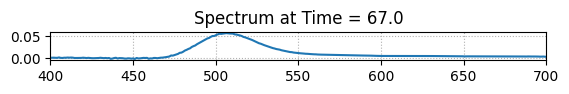

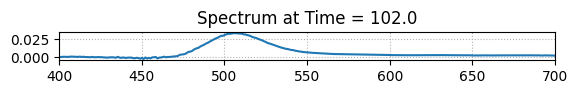

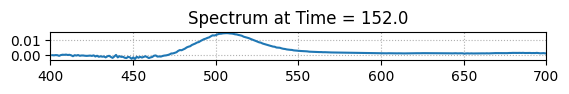

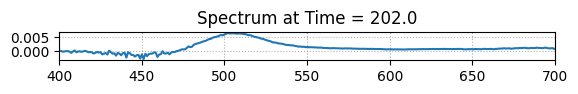

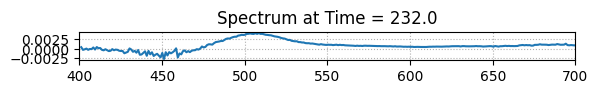

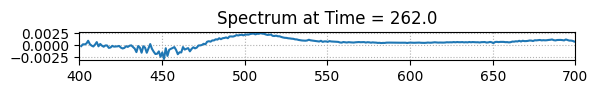

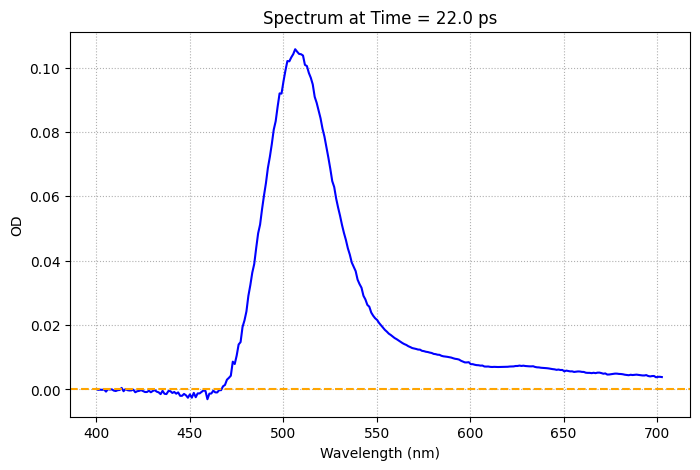

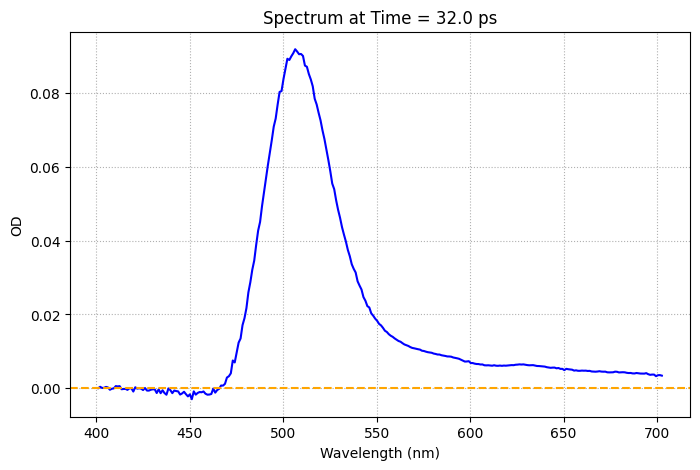

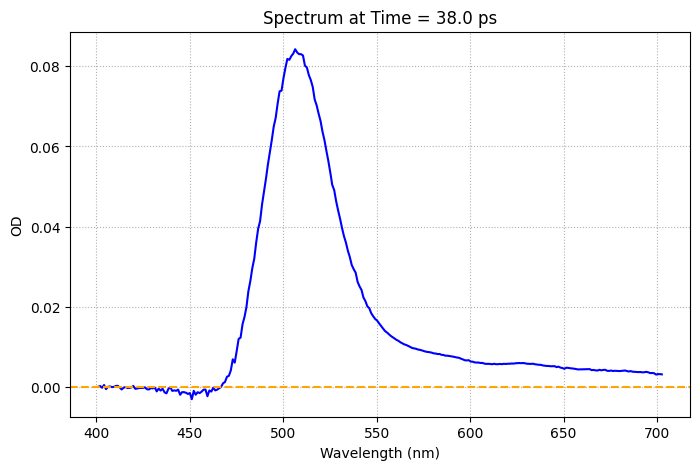

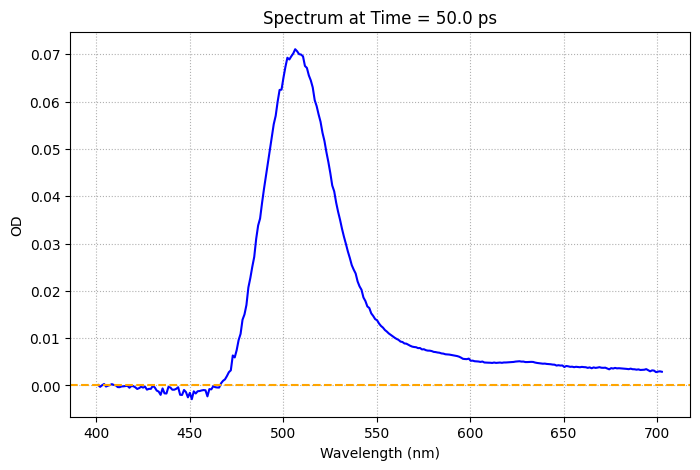

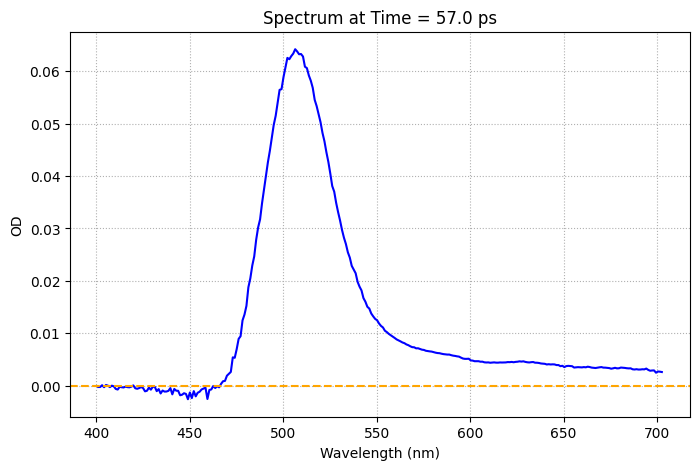

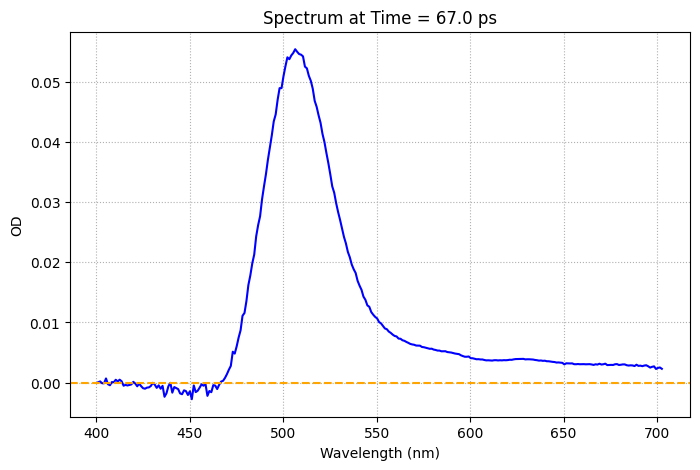

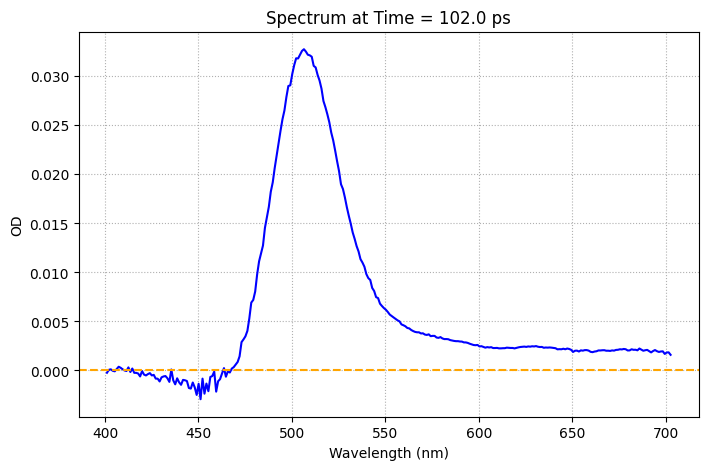

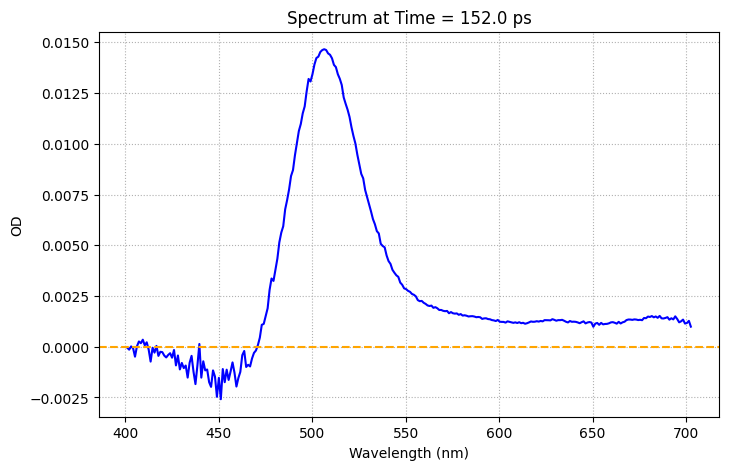

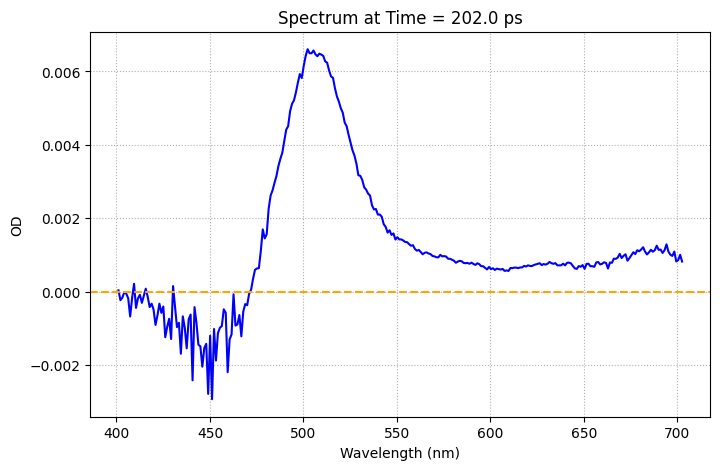

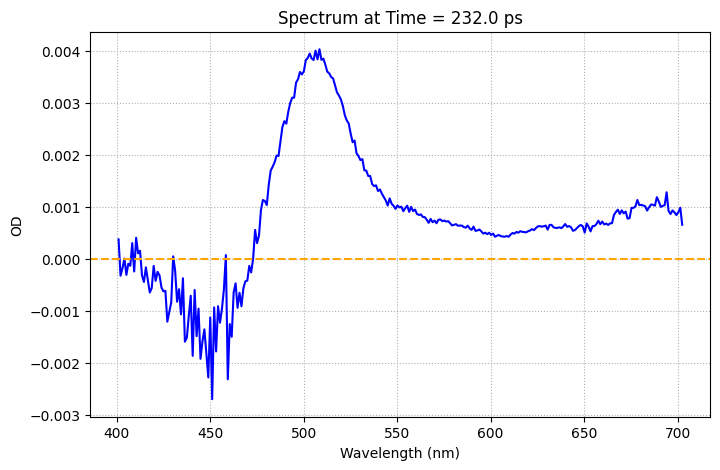

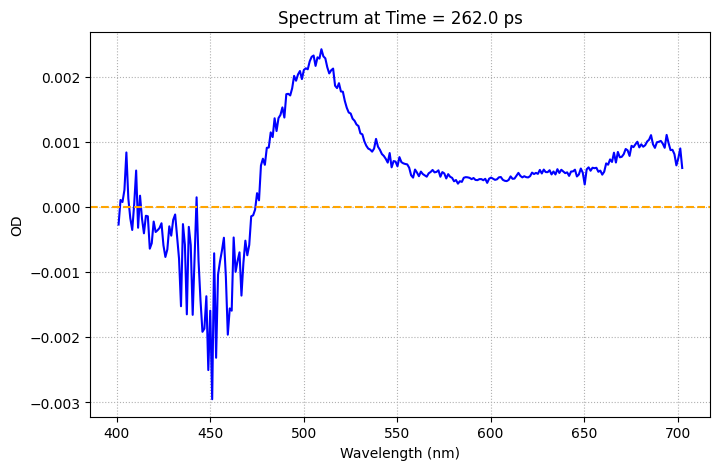

In [ ]:
# OD vs Wavelength
time_index = [] # For selected time values  

time_indices = [int(np.argmin(np.abs(time - t))) for t in time_index] #Floating values to nearest indices 

for i,t in enumerate(time_indices):
    plt.subplot(len(time_index), 1, i+1)
    plt.title('Spectrum at Time = {}'.format(round(time[t],2)))
    plt.plot(wavelengths,od_values[t, :])
    plt.xlim(400,700)
    plt.grid(linestyle=':')
    plt.show()

for i,t in enumerate(time_indices):
    plt.figure(figsize=(8, 5))
    plt.plot(wavelengths, od_values[t, :], color='blue')
    plt.axhline(y=0, color='orange', linestyle='--')  # Dashed zero-line
    plt.title(f'Spectrum at Time = {round(time[t],2)} ps')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('OD')
    plt.grid(linestyle=':')
    plt.show()

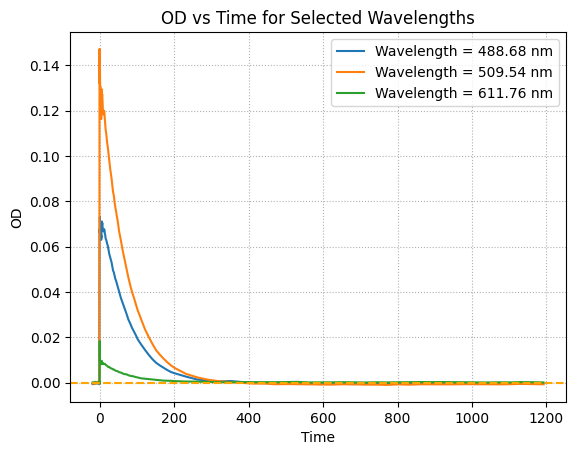

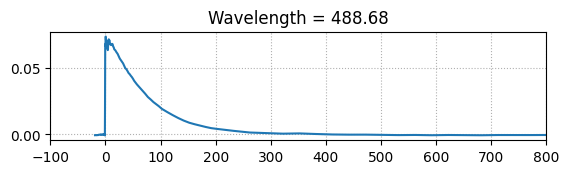

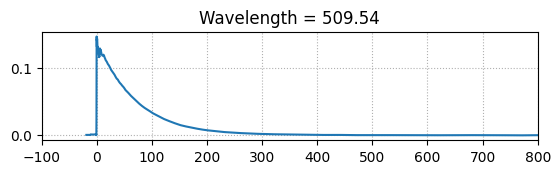

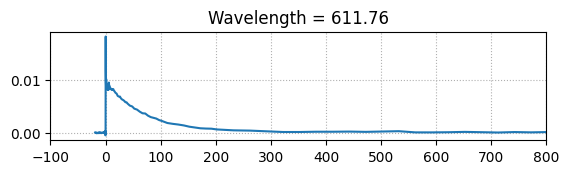

In [82]:
# OD vs time for different wavelengths 
import matplotlib.pyplot as plt 

w_index = [488.68, 509.54, 611.76]

w_indices = [int(np.argmin(np.abs(wavelengths - w))) for w in w_index]
                      
for i, w in enumerate(w_indices): 
    plt.plot(time, od_values[:, w], label=f'Wavelength = {round(wavelengths[w], 2)} nm')

plt.axhline(y=0, color='orange', linestyle='--')  # Dashed zero-line
plt.title('OD vs Time for Selected Wavelengths')
plt.xlabel('Time')
plt.ylabel('OD')
plt.legend()
plt.grid(linestyle=':')
plt.show()

for i, w in enumerate(w_indices):
    plt.subplot(len(w_index), 1, i+1)
    plt.title('Wavelength = {}'.format(round(wavelengths[w],2)))
    plt.plot(time ,od_values[:, w])
    plt.xlim(-100,800)
    plt.grid(linestyle=':')
    plt.show()

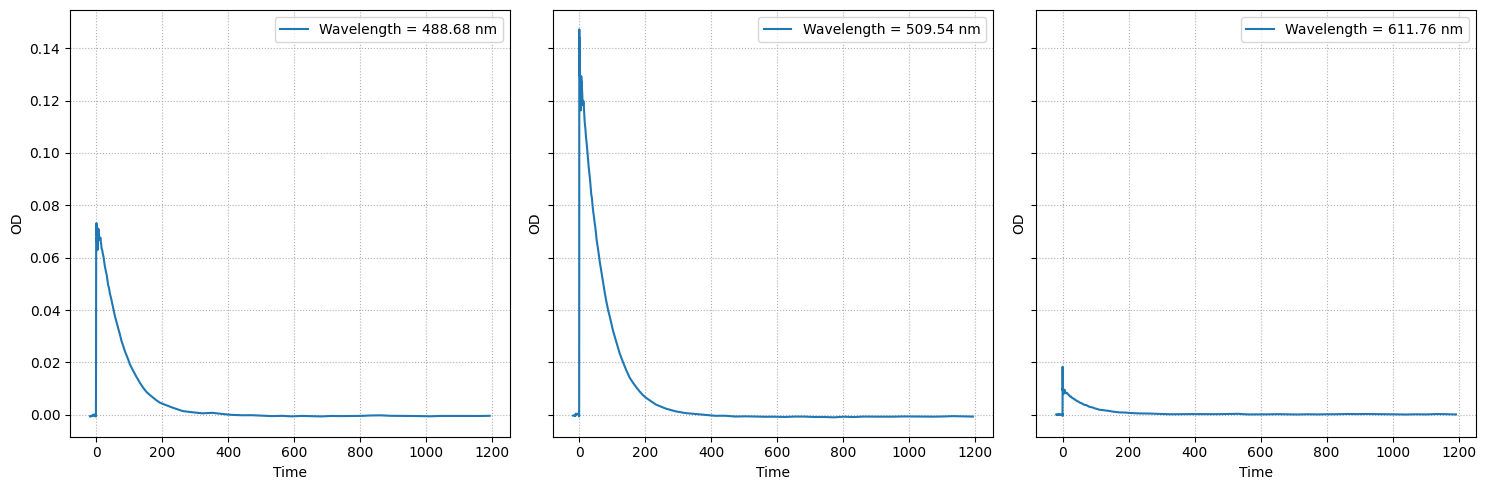

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i,w in enumerate(w_indices):
    axes[i].plot(time, od_values[:, w], label=f'Wavelength = {round(wavelengths[w], 2)} nm')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('OD')
    axes[i].legend(loc='best')
    axes[i].grid(linestyle=':')

plt.tight_layout()
plt.show()

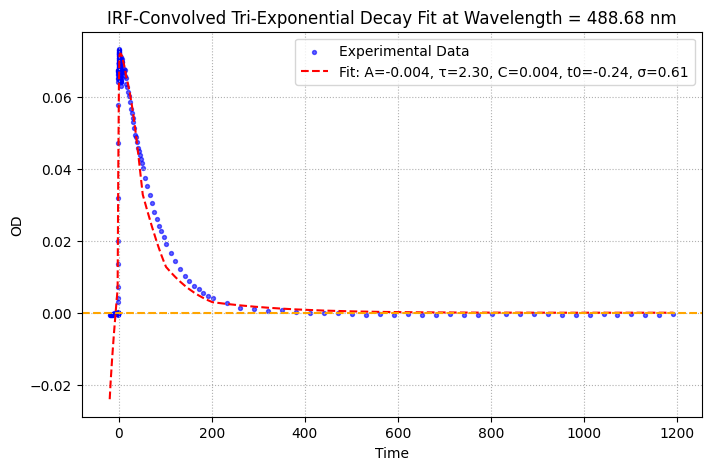

In [ ]:
# OD vs time for different wavelengths (FIT)
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve

target_wavelength = 488.68
wavelength_index = np.argmin(np.abs(wavelengths - target_wavelength))
y = od_values[:, wavelength_index]

def irf(t, t0, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((t - t0) ** 2) / (2 * sigma ** 2))

def fit(t, A1, tau1, c):
    return A1 * np.exp(-t/tau1) + c 

# Define convolution model (IRF + Decay)
def convolved_model(t, A1, tau1, c, t0, sigma):
    decay = fit(t, A1, tau1, c)
    irf_curve = irf(t, t0, sigma)
    return fftconvolve(decay, irf_curve, mode='same')

initial_guess =  [0.1, 50, 0, 2, 1] #[A, τ, C, t0, σ]

try:
    popt, _ = curve_fit(convolved_model, time, y, maxfev=10000)

    # Generate fitted curve
    fitted_curve = convolved_model(time, *popt)

    # Plot experimental data and fit
    plt.figure(figsize=(8, 5))
    plt.scatter(time, y, color='blue', label='Experimental Data', s=8, alpha=0.6)
    plt.plot(time, fitted_curve, color='red', linestyle='--', 
         label=f'Fit: A={popt[0]:.3f}, τ={popt[1]:.2f}, C={popt[2]:.3f}, t0={popt[3]:.2f}, σ={popt[4]:.2f}')
    plt.axhline(y=0, color='orange', linestyle='--')  # Zero-line
    plt.xlabel('Time')
    plt.ylabel('OD')
    plt.title(f'IRF-Convolved Tri-Exponential Decay Fit at Wavelength = {round(wavelengths[wavelength_index], 2)} nm')
    plt.legend()
    plt.grid(linestyle=':')
    plt.show()
except RuntimeError:
    print("Curve fitting failed. Try adjusting initial guesses.")

In [189]:
# %% 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve

# Read file
data = pd.read_csv(r"DAS_ACN_10uL (1).csv")

# Extract values
time = data.iloc[1:, 0].astype(float).values  # Time values
wavelengths = data.columns[1:].astype(float).values  # Wavelengths
od_values = data.iloc[1:, 1:].astype(float).values  # OD values

# Select the wavelength closest to 488.68 nm
target_wavelength = 488.68
wavelength_index = np.argmin(np.abs(wavelengths - target_wavelength))

# Get OD values for the selected wavelength
y_data = od_values[:, wavelength_index]

# Define Gaussian IRF function
def irf(t, t0, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((t - t0) ** 2) / (2 * sigma ** 2))

# Define single-exponential decay function
def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C

# Define convolution model (IRF + Decay)
def convolved_model(t, A, tau, C, t0, sigma):
    decay = exp_decay(t, A, tau, C)
    irf_curve = irf(t, t0, sigma)
    return fftconvolve(decay, irf_curve, mode='same')

# Initial parameter guesses: [A, τ, C, t0, σ]
initial_guess = [0.1, 50, 0.005, 2, 1]

# Fit the data using curve_fit
try:
    popt, _ = curve_fit(convolved_model, time, y_data, p0=initial_guess, maxfev=10000)

    # Generate fitted curve
    fitted_curve = convolved_model(time, *popt)

    # Plot experimental data and fit
    plt.figure(figsize=(8, 5))
    plt.scatter(time, y_data, color='blue', label='Experimental Data', s=8, alpha=0.6)
    plt.plot(time, fitted_curve, color='red', linestyle='--', 
             label=f'Fit: A={popt[0]:.3f}, τ={popt[1]:.2f}, C={popt[2]:.3f}, t0={popt[3]:.2f}, σ={popt[4]:.2f}')
    plt.axhline(y=0, color='orange', linestyle='--')  # Zero-line
    plt.xlabel('Time')
    plt.ylabel('OD')
    plt.title(f'IRF-Convolved Single-Exponential Decay Fit at Wavelength = {round(wavelengths[wavelength_index], 2)} nm')
    plt.legend()
    plt.grid(linestyle=':')
    plt.show()
except RuntimeError:
    print("Curve fitting failed. Try adjusting initial guesses.")

Curve fitting failed. Try adjusting initial guesses.
